<a href="https://colab.research.google.com/github/ShinyRyo/signate2business/blob/main/%E5%82%B5%E5%8B%99%E4%B8%8D%E5%B1%A5%E8%A1%8C/%E3%83%87%E3%83%BC%E3%82%BF%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ライブラリのインポート

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

#データの読み込み

In [ ]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/signate/債務不履行/data/'

In [ ]:
train = pd.read_csv(base_dir + 'train.csv')
test = pd.read_csv(base_dir + 'test.csv')

#データ分析

In [ ]:
train.head()

,id,loan_amnt,term,interest_rate,grade,employment_length,purpose,credit_score,application_type,loan_status
0,88194295,1800.0,3 years,14.49,C4,NaN,debt_consolidation,665.0,Individual,FullyPaid
1,5146039,1200.0,5 years,16.29,C4,2 years,debt_consolidation,700.0,Individual,ChargedOff
2,3095896,2000.0,5 years,21.98,E4,10 years,home_improvement,670.0,Individual,FullyPaid
3,88625044,1000.0,3 years,8.59,A5,4 years,debt_consolidation,710.0,Individual,FullyPaid
4,1178189,1500.0,3 years,13.99,C1,4 years,debt_consolidation,680.0,Individual,FullyPaid


##目的変数が質的データの場合

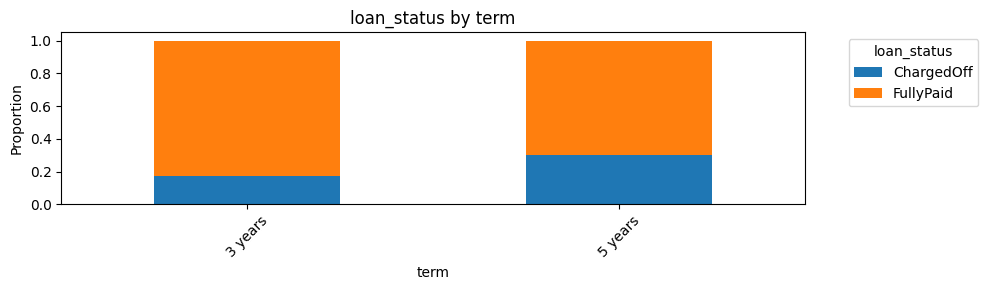

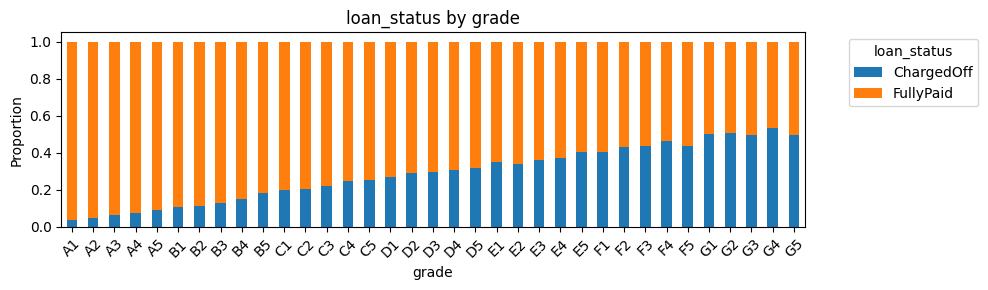

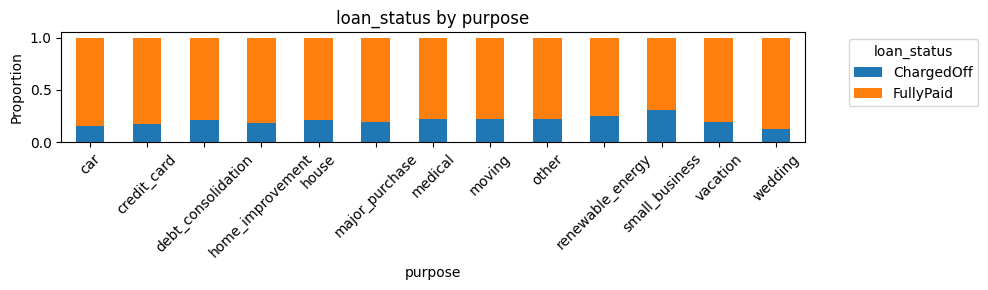

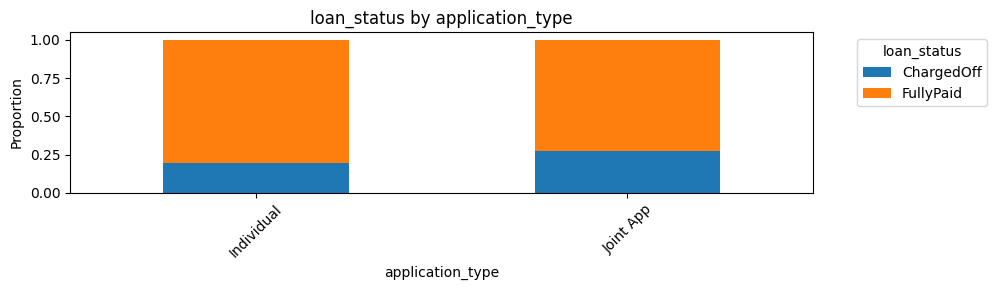

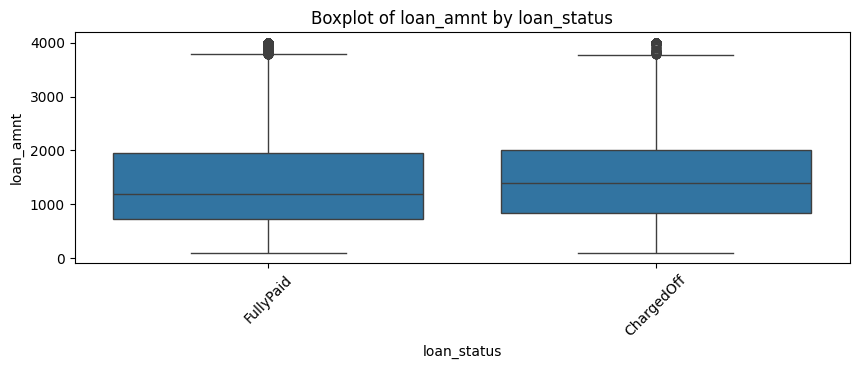

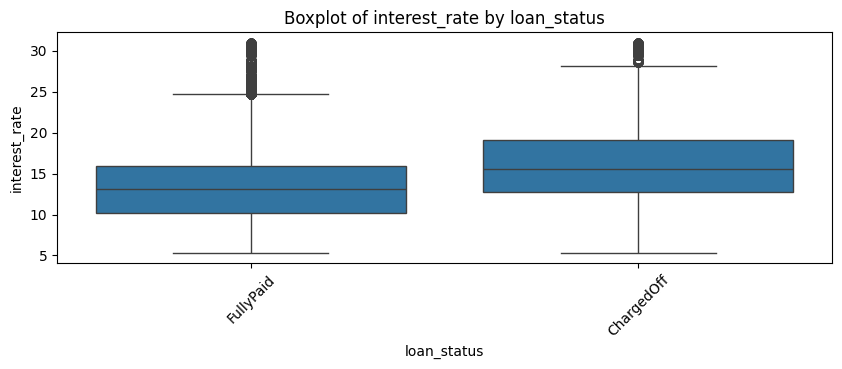

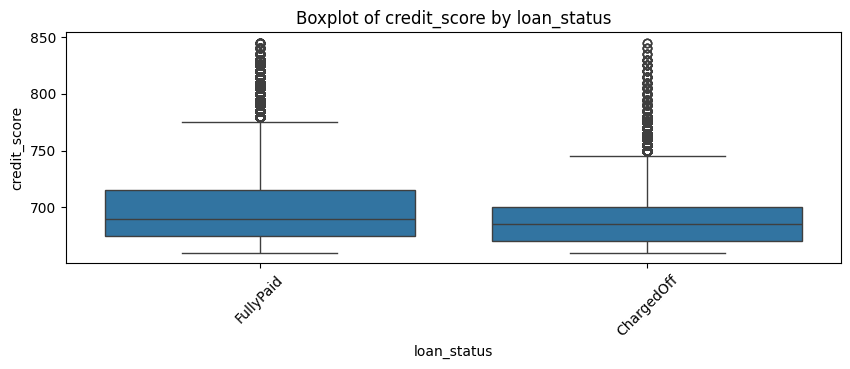

In [ ]:
def perform_initial_analysis(df, category_vars, quantitative_vars, target_var):
    """
    指定されたデータフレームに対し、カテゴリカル変数の積み上げ棒グラフと
    量的変数の箱ひげ図を描画する汎用関数。目的変数が質的データであることを前提とする。

    Parameters:
    - df: DataFrame, 分析対象のデータフレーム
    - category_vars: list, 可視化したいカテゴリカル変数のリスト
    - quantitative_vars: list, 可視化したい量的変数のリスト
    - target_var: str, 目的変数（カテゴリカル変数）
    """
    # カテゴリカル変数の積み上げ棒グラフ
    for category_var in category_vars:
        if category_var != target_var:  # 目的変数自体とのクロス集計は除外
            cross_tab = pd.crosstab(df[category_var], df[target_var], normalize='index')
            cross_tab.plot(kind='bar', stacked=True, figsize=(10, 3))
            plt.title(f'{target_var} by {category_var}')
            plt.xlabel(category_var)
            plt.ylabel('Proportion')
            plt.xticks(rotation=45)
            plt.legend(title=target_var, bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            plt.show()

    # 量的変数の箱ひげ図
    for quant_var in quantitative_vars:
        plt.figure(figsize=(10, 3))
        sns.boxplot(x=target_var, y=quant_var, data=df)
        plt.title(f'Boxplot of {quant_var} by {target_var}')
        plt.xlabel(target_var)
        plt.ylabel(quant_var)
        plt.xticks(rotation=45)
        plt.show()

# カテゴリカル変数リストと量的変数リストの定義
category_vars = ['term', 'grade', 'purpose', 'application_type']
quantitative_vars = ['loan_amnt', 'interest_rate', 'credit_score']

# 汎用関数を実行
perform_initial_analysis(train, category_vars, quantitative_vars, 'loan_status')

##目的変数が量的データの場合

#施策の生成

##1. ローン期間の最適化
具体例: 短期ローンの奨励

理由: 積み上げ棒グラフから、短期ローン（例：3年）の完済率が高いことが示唆されている場合、短期ローンを奨励することで全体のデフォルト率を低下させることができます。

施策内容: 利息率の割引や手数料の免除などのインセンティブを短期ローンに提供する。また、短期ローンを選択した顧客に対して、返済スケジュールの柔軟性を提供するなどのサービスを実施します。


##2. クレジットスコアを基にしたリスク調整
具体例: クレジットスコアベースの利息割引

理由: 箱ひげ図から、高いクレジットスコアを持つ顧客のデフォルト率が低いことが示されている場合、クレジットスコアをリスク評価により強く反映させることが可能です。

施策内容: クレジットスコアが一定基準を超える顧客に対して、利息率の割引を提供します。これにより、信用力の高い顧客のロイヤルティを高め、リスクの低いローンポートフォリオを構築します。

#ロジックの生成

##短期ローン優遇ロジック

簡単のため該当するカテゴリに対して5%の金利の優遇を適応します。

In [ ]:
def loan_term_discount(df, term_threshold='3 years', term_discount=0.005):
    # 条件に基づいて割引率を適用
    df['discounted_rate'] = df.apply(
        lambda row: term_discount if row['term'] == term_threshold else row['discounted_rate'],
        axis=1
    )

    return df

##優良クレジットスコア優遇ロジック

簡単のため閾値以上の数値を有する人に対して5%の金利の優遇を適応します。

In [ ]:
def credit_score_discount(df, credit_score_discount=0.005):
    credit_score_mean = df['credit_score'].mean()

    df['discounted_rate'] = df.apply(
        lambda row: row['discounted_rate'] + credit_score_discount if row['credit_score'] >= credit_score_mean else row['discounted_rate'],
        axis=1
    )

    return df

##ロジックの適応

discounted_rateカラムを作成して誰がどの程度の金利の優遇があるかを算出します。

In [ ]:
train_df = train.copy()

In [ ]:
train_df['discounted_rate'] = 0

In [ ]:
train_df.head()

,id,loan_amnt,term,interest_rate,grade,employment_length,purpose,credit_score,application_type,loan_status,discounted_rate
0,88194295,1800.0,3 years,14.49,C4,NaN,debt_consolidation,665.0,Individual,FullyPaid,0
1,5146039,1200.0,5 years,16.29,C4,2 years,debt_consolidation,700.0,Individual,ChargedOff,0
2,3095896,2000.0,5 years,21.98,E4,10 years,home_improvement,670.0,Individual,FullyPaid,0
3,88625044,1000.0,3 years,8.59,A5,4 years,debt_consolidation,710.0,Individual,FullyPaid,0
4,1178189,1500.0,3 years,13.99,C1,4 years,debt_consolidation,680.0,Individual,FullyPaid,0


In [ ]:
discounted_train_df = loan_term_discount(train_df)
discounted_train_df

,id,loan_amnt,term,interest_rate,grade,employment_length,purpose,credit_score,application_type,loan_status,discounted_rate
0,88194295,1800.0,3 years,14.49,C4,NaN,debt_consolidation,665.0,Individual,FullyPaid,0.005
1,5146039,1200.0,5 years,16.29,C4,2 years,debt_consolidation,700.0,Individual,ChargedOff,0.000
2,3095896,2000.0,5 years,21.98,E4,10 years,home_improvement,670.0,Individual,FullyPaid,0.000
3,88625044,1000.0,3 years,8.59,A5,4 years,debt_consolidation,710.0,Individual,FullyPaid,0.005
4,1178189,1500.0,3 years,13.99,C1,4 years,debt_consolidation,680.0,Individual,FullyPaid,0.005
...,...,...,...,...,...,...,...,...,...,...,...
242151,3218672,1500.0,3 years,10.16,B1,5 years,debt_consolidation,690.0,Individual,FullyPaid,0.005
242152,91332527,1930.0,3 years,12.74,C1,10 years,other,695.0,Individual,ChargedOff,0.005
242153,123604615,780.0,3 years,14.08,C3,10 years,debt_consolidation,730.0,Individual,FullyPaid,0.005
242154,2306469,472.5,3 years,19.72,D5,NaN,home_improvement,685.0,Individual,FullyPaid,0.005


In [ ]:
discounted_train_df = credit_score_discount(discounted_train_df)
discounted_train_df

,id,loan_amnt,term,interest_rate,grade,employment_length,purpose,credit_score,application_type,loan_status,discounted_rate
0,88194295,1800.0,3 years,14.49,C4,NaN,debt_consolidation,665.0,Individual,FullyPaid,0.005
1,5146039,1200.0,5 years,16.29,C4,2 years,debt_consolidation,700.0,Individual,ChargedOff,0.005
2,3095896,2000.0,5 years,21.98,E4,10 years,home_improvement,670.0,Individual,FullyPaid,0.000
3,88625044,1000.0,3 years,8.59,A5,4 years,debt_consolidation,710.0,Individual,FullyPaid,0.010
4,1178189,1500.0,3 years,13.99,C1,4 years,debt_consolidation,680.0,Individual,FullyPaid,0.005
...,...,...,...,...,...,...,...,...,...,...,...
242151,3218672,1500.0,3 years,10.16,B1,5 years,debt_consolidation,690.0,Individual,FullyPaid,0.005
242152,91332527,1930.0,3 years,12.74,C1,10 years,other,695.0,Individual,ChargedOff,0.005
242153,123604615,780.0,3 years,14.08,C3,10 years,debt_consolidation,730.0,Individual,FullyPaid,0.010
242154,2306469,472.5,3 years,19.72,D5,NaN,home_improvement,685.0,Individual,FullyPaid,0.005


#シナリオデータの生成

discounted_rateカラムに累積したスコアを適応します。

In [ ]:
train4sim = train.copy()

In [ ]:
train4sim['interest_rate'] = train4sim['interest_rate'] - discounted_train_df['discounted_rate']
train4sim

,id,loan_amnt,term,interest_rate,grade,employment_length,purpose,credit_score,application_type,loan_status
0,88194295,1800.0,3 years,14.485,C4,NaN,debt_consolidation,665.0,Individual,FullyPaid
1,5146039,1200.0,5 years,16.285,C4,2 years,debt_consolidation,700.0,Individual,ChargedOff
2,3095896,2000.0,5 years,21.980,E4,10 years,home_improvement,670.0,Individual,FullyPaid
3,88625044,1000.0,3 years,8.580,A5,4 years,debt_consolidation,710.0,Individual,FullyPaid
4,1178189,1500.0,3 years,13.985,C1,4 years,debt_consolidation,680.0,Individual,FullyPaid
...,...,...,...,...,...,...,...,...,...,...
242151,3218672,1500.0,3 years,10.155,B1,5 years,debt_consolidation,690.0,Individual,FullyPaid
242152,91332527,1930.0,3 years,12.735,C1,10 years,other,695.0,Individual,ChargedOff
242153,123604615,780.0,3 years,14.070,C3,10 years,debt_consolidation,730.0,Individual,FullyPaid
242154,2306469,472.5,3 years,19.715,D5,NaN,home_improvement,685.0,Individual,FullyPaid


#シミュレーション

In [ ]:
import lightgbm as lgb

# 保存されたモデルを読み込む
loaded_model = lgb.Booster(model_file='model.txt')

##モデルの確認

In [ ]:
train4pred = train.copy()
test4pred = test.copy()

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [ ]:
target_columns = list(set(train4pred.columns) - set(test4pred.columns))[0]
categorical_cols = train4pred.select_dtypes(include=['object', 'category']).columns.drop(target_columns, errors='ignore').tolist()
numerical_cols = train4pred.select_dtypes(include=[np.number]).columns.drop(target_columns, errors='ignore').tolist()

le_exps = {}
# カテゴリカルデータをラベルエンコーディング
for col in categorical_cols:
    le = LabelEncoder()
    all_data = pd.concat([train4pred[col], train4pred[col]], axis=0).astype(str)
    le.fit(all_data)
    train4pred[col] = le.transform(train4pred[col].astype(str))
    test4pred[col] = le.transform(test4pred[col].astype(str))
    le_exps[col] = le

# 目的変数をエンコード
le_target = LabelEncoder()
train4pred[target_columns] = le_target.fit_transform(train4pred[target_columns])

# 目的変数と特徴量を分割
X_train = train4pred.drop(columns=[target_columns])
y_train = train4pred[target_columns]

In [ ]:
le_exps

{'term': LabelEncoder(),
 'grade': LabelEncoder(),
 'employment_length': LabelEncoder(),
 'purpose': LabelEncoder(),
 'application_type': LabelEncoder()}

In [ ]:
# LightGBMのデータセット形式に変換
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_cols, free_raw_data=False)

In [ ]:
loaded_model.predict(X_train)

array([0.53527939, 0.76521129, 0.68946976, ..., 0.81926052, 0.72597581,
       0.6300575 ])

In [ ]:
train4sim.head()

,id,loan_amnt,term,interest_rate,grade,employment_length,purpose,credit_score,application_type,loan_status
0,88194295,1800.0,3 years,14.485,C4,NaN,debt_consolidation,665.0,Individual,FullyPaid
1,5146039,1200.0,5 years,16.285,C4,2 years,debt_consolidation,700.0,Individual,ChargedOff
2,3095896,2000.0,5 years,21.980,E4,10 years,home_improvement,670.0,Individual,FullyPaid
3,88625044,1000.0,3 years,8.580,A5,4 years,debt_consolidation,710.0,Individual,FullyPaid
4,1178189,1500.0,3 years,13.985,C1,4 years,debt_consolidation,680.0,Individual,FullyPaid


##シナリオデータの確認

In [ ]:
train4sim = train.copy()
test4sim = test.copy()

In [ ]:
le_exps

{'term': LabelEncoder(),
 'grade': LabelEncoder(),
 'employment_length': LabelEncoder(),
 'purpose': LabelEncoder(),
 'application_type': LabelEncoder()}

In [ ]:
# le_expsを使う
# カテゴリカルデータをラベルエンコーディング
for col in categorical_cols:
    le = le_exps[col]
    train4sim[col] = le.transform(train4sim[col].astype(str))

In [ ]:
train4sim.head()

,id,loan_amnt,term,interest_rate,grade,employment_length,purpose,credit_score,application_type,loan_status
0,88194295,1800.0,0,14.49,13,11,2,665.0,0,FullyPaid
1,5146039,1200.0,1,16.29,13,3,2,700.0,0,ChargedOff
2,3095896,2000.0,1,21.98,23,2,3,670.0,0,FullyPaid
3,88625044,1000.0,0,8.59,4,5,2,710.0,0,FullyPaid
4,1178189,1500.0,0,13.99,10,5,2,680.0,0,FullyPaid


##シミュレーション前

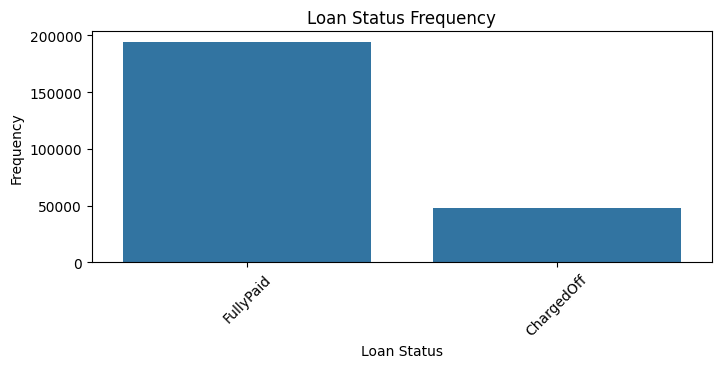

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# loan_statusの値のカウントを計算
loan_status_counts = train['loan_status'].value_counts()

# 棒グラフで可視化
plt.figure(figsize=(8, 3))
sns.barplot(x=loan_status_counts.index, y=loan_status_counts.values)
plt.title('Loan Status Frequency')
plt.xlabel('Loan Status')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # X軸のラベルが重ならないように回転
plt.show()

##シミュレーション後

In [ ]:
simX = train4sim.drop(columns=['loan_status'])
simy = train4sim['loan_status']

In [ ]:
# 元のモデルを使用して予測を行う
y_pred_simulated = loaded_model.predict(simX, num_iteration=loaded_model.best_iteration)

# 予測結果を0または1に丸める
y_pred_simulated_rounded = np.round(y_pred_simulated)

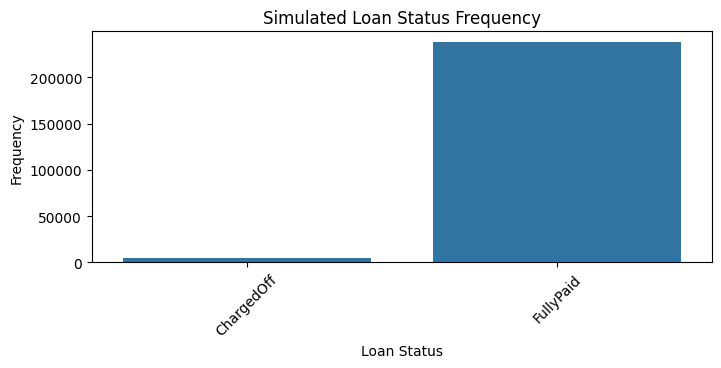

In [ ]:
# LabelEncoderインスタンス（loan_statusのエンコーディングに使用）
# このlabel_encoderは、以前にloan_statusをエンコードするためにfitされたものです
# label_encoder = encoders[target_column]

# エンコードされた予測結果をデコード
y_pred_simulated_decoded = le_target.inverse_transform(y_pred_simulated_rounded.astype(int))

# デコードされた値のカウントを計算
unique, counts = np.unique(y_pred_simulated_decoded, return_counts=True)

# 棒グラフで可視化
plt.figure(figsize=(8, 3))
sns.barplot(x=unique, y=counts)
plt.title('Simulated Loan Status Frequency')
plt.xlabel('Loan Status')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # X軸のラベルが重ならないように回転
plt.show()